In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .**

### Imports

In [2]:
import tensorflow as tf 
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

## Reading File

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis github/Sentiment-Analysis/sentimentanalysisdata.csv', encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Shuffling and Taking fraction of Dataset

In [5]:
df = df.sample(frac=1)
df = df.sample(n=100000)
df.head()

,target,ids,date,flag,user,text
525935,0,2194091337,Tue Jun 16 09:19:58 PDT 2009,NO_QUERY,XStephanieAnneX,Had my jab! last 1 in 5 months time
1346080,4,2044194161,Fri Jun 05 09:00:23 PDT 2009,NO_QUERY,dharshana,@jonnerz Thank you!
1293520,4,2003218753,Tue Jun 02 06:07:02 PDT 2009,NO_QUERY,heyyitskate,hey! warning. gonna start tweeting alot.
204303,0,1972583779,Sat May 30 09:30:02 PDT 2009,NO_QUERY,vanessatorweihe,carroll university is stealing all my money
1229137,4,1991312224,Mon Jun 01 06:48:31 PDT 2009,NO_QUERY,yadikeith,@eyaustin lol. Have u thought about how many t...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 525935 to 756025
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  100000 non-null  int64 
 1   ids     100000 non-null  int64 
 2   date    100000 non-null  object
 3   flag    100000 non-null  object
 4   user    100000 non-null  object
 5   text    100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [7]:
df.target.nunique()

2

## Preprocessing data


---



1. Removing username and urls.
2. Cleaning the text by removing punctuation, stopwords and special symbols.
3. Converting target values (0->0 and 4->1).




In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess():
    def removeusername(x):
        arr=x.split()
        if arr[0].startswith('@'):
            arr.pop(0)
        return ' '.join(arr)

    def removeurl(x):
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x, flags=re.MULTILINE)
        return text

    def clean(x):
        text = re.sub('[^A-Za-z]+', " ", x)
        return text

    def stopWord(x):
        text = [word.lower() for word in x if word.lower() not in stopwords.words('english')]
        return text

    def createbinary(x):
        if x==4:
            return 1
        else:
            return 0

    df['text']=df['text'].apply(lambda x: removeusername(x))
    df['text']=df['text'].apply(lambda x: removeurl(x))
    df['text']=df['text'].apply(lambda x: clean(x))
    df['text']=df['text'].apply(lambda x: word_tokenize(x))
    df["text"]=df['text'].apply(stopWord)
    df['text'] = df['text'].apply(lambda x: ' '.join(x))
    df['target']=df['target'].apply(createbinary)

In [10]:
preprocess()
df.head()

,target,ids,date,flag,user,text
525935,0,2194091337,Tue Jun 16 09:19:58 PDT 2009,NO_QUERY,XStephanieAnneX,jab last months time
1346080,1,2044194161,Fri Jun 05 09:00:23 PDT 2009,NO_QUERY,dharshana,thank
1293520,1,2003218753,Tue Jun 02 06:07:02 PDT 2009,NO_QUERY,heyyitskate,hey warning gon na start tweeting alot
204303,0,1972583779,Sat May 30 09:30:02 PDT 2009,NO_QUERY,vanessatorweihe,carroll university stealing money
1229137,1,1991312224,Mon Jun 01 06:48:31 PDT 2009,NO_QUERY,yadikeith,lol u thought many times u see theaters


## Splitting Data into Training and Testing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


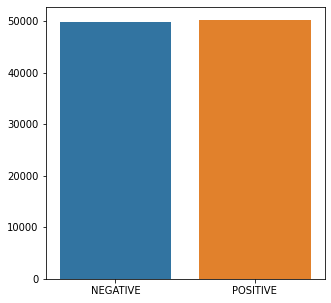

In [42]:
plt.figure(figsize=(5, 5))
sns.barplot(['NEGATIVE', 'POSITIVE'], [len(df[df['target']==0]), len(df[df['target']==1])])

### Dataset is balanced

In [17]:
df = df[['text', 'target']]

In [18]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['text_len'] = df['text'].astype(str).apply(len)

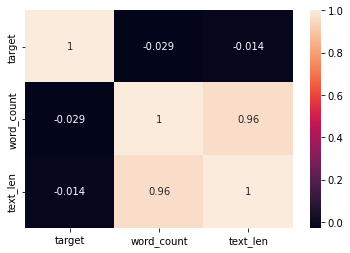

In [21]:
sns.heatmap(df.corr(), annot=True)

### We can see that word count and text length has near 0 correlation with the target.

## Splitting data into training and testing

In [22]:
x=df['text']
y=df['target']

In [23]:
x.head()

525935                        jab last months time
1346080                                      thank
1293520     hey warning gon na start tweeting alot
204303           carroll university stealing money
1229137    lol u thought many times u see theaters
Name: text, dtype: object

In [24]:
y.head()

525935     0
1346080    1
1293520    1
204303     0
1229137    1
Name: target, dtype: int64

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=101, test_size=0.2)

In [26]:
train_tweets, test_tweets, train_label, test_label=[], [], [], []
for i in x_train:
    train_tweets.append(str(i))
for i in x_test:
    test_tweets.append(str(i))
for i in y_train:
    train_label.append(i)
for i in y_test:
    test_label.append(i)

In [27]:
del x, y, x_train, y_train, x_test, y_test

In [28]:
#Declaring some default values

vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [29]:
#Training the tokenizer on our dataset

tokenizer=keras.preprocessing.text.Tokenizer(oov_token=oov_tok, num_words=4000)
tokenizer.fit_on_texts(train_tweets)
word_index=tokenizer.word_index

In [30]:
print(list(word_index)[:10])

['<OOV>', 'good', 'day', 'get', 'like', 'go', 'quot', 'got', 'today', 'love']


In [31]:
#Converting the tweets to neumeric data as tensors
sequences=tokenizer.texts_to_sequences(train_tweets)
sequences

[[1, 284, 201, 19, 343, 1208, 29, 2448, 378, 529],
 [65, 320, 1006],
 [300, 1, 578, 1, 1, 521, 66, 1, 129],
 [1, 38, 23, 431],
 [348, 991, 1101, 529, 513, 850, 522, 3888, 18],
 [583, 59, 618, 1, 1, 1, 335, 83, 59, 1],
 [1, 379, 140, 2159, 938, 45, 3],
 [535, 1321, 3, 12, 9, 328, 1, 225, 1, 1, 94, 396, 1798, 3],
 [1063, 370, 28],
 [1, 957, 1894, 786, 584, 1895],
 [182, 1, 9, 48, 528, 100, 499, 100, 499, 2160, 2522, 62],
 [892, 3, 1707, 158, 978, 322, 756],
 [7, 282, 1559, 1, 7, 176, 1832, 2161, 35, 3715, 1, 1405, 1, 42],
 [359, 4, 8, 3889, 1049],
 [270],
 [13, 75, 17, 339, 876, 1, 574, 898, 183, 228, 8, 85, 1305, 354],
 [20, 1560, 41, 262, 2],
 [5, 3268, 2918, 8, 948, 1, 1306, 69, 632, 614, 17],
 [2030, 1, 3127],
 [408, 3, 1511, 173],
 [58, 271, 58, 209, 7, 508, 1799, 7],
 [78, 103, 206, 1863, 544, 70, 1, 70],
 [68, 1532, 1],
 [11, 66, 136, 18, 1],
 [662, 2, 239, 48, 223],
 [66, 15],
 [18, 261, 62, 647, 102, 2523, 3269, 692, 226],
 [361, 1, 1, 1, 96, 51, 484, 254, 3270, 1, 2734],
 [787,

In [32]:
#Adding padding to equal the size of tensors

padded=keras.preprocessing.sequence.pad_sequences(sequences, maxlen=120, truncating='post')

In [33]:
print(padded)

[[   0    0    0 ... 2448  378  529]
 [   0    0    0 ...   65  320 1006]
 [   0    0    0 ...   66    1  129]
 ...
 [   0    0    0 ...  110   12    1]
 [   0    0    0 ...    1  352   38]
 [   0    0    0 ...  591  407  528]]


In [34]:
#Preprocessing testing data

In [35]:
test_sequence=tokenizer.texts_to_sequences(test_tweets)
test_padded=keras.preprocessing.sequence.pad_sequences(test_sequence, maxlen=120, truncating='post')

In [36]:
#Creating the model

model=keras.models.Sequential([
    keras.layers.Embedding(40000, 16, input_length=120),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

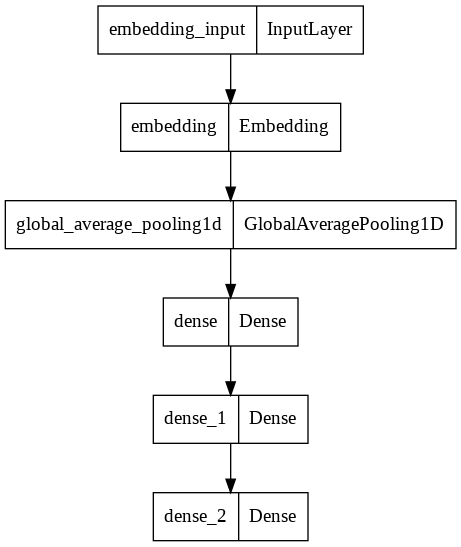

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643,201
Trainable params: 643,201
Non-trainable params: 0
__________________________________________________

In [40]:
train_label=np.array(train_label)
test_label=np.array(test_label)

In [41]:
train_label[:50]

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1])

In [ ]:
#Training the model

In [ ]:
history=model.fit(padded, train_label, validation_split=0.2, epochs=10)

Epoch 1/10
32000/32000 [==============================] - 184s 6ms/step - loss: 0.4616 - accuracy: 0.7809 - val_loss: 0.4545 - val_accuracy: 0.7844
Epoch 2/10
32000/32000 [==============================] - 178s 6ms/step - loss: 0.4423 - accuracy: 0.7917 - val_loss: 0.4414 - val_accuracy: 0.7929
Epoch 3/10
32000/32000 [==============================] - 206s 6ms/step - loss: 0.4366 - accuracy: 0.7952 - val_loss: 0.4364 - val_accuracy: 0.7958
Epoch 4/10
32000/32000 [==============================] - 222s 7ms/step - loss: 0.4323 - accuracy: 0.7982 - val_loss: 0.4429 - val_accuracy: 0.7907
Epoch 5/10
32000/32000 [==============================] - 186s 6ms/step - loss: 0.4296 - accuracy: 0.7996 - val_loss: 0.4352 - val_accuracy: 0.7978
Epoch 6/10
32000/32000 [==============================] - 178s 6ms/step - loss: 0.4268 - accuracy: 0.8014 - val_loss: 0.4321 - val_accuracy: 0.8003
Epoch 7/10
32000/32000 [==============================] - 178s 6ms/step - loss: 0.4241 - accuracy: 0.8028 - val_

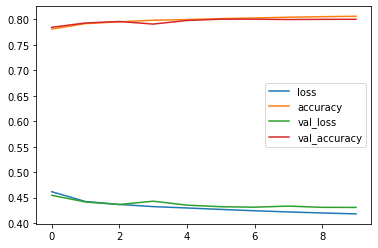

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.save('/content/drive/MyDrive/Sentiment Analysis github/Sentiment-Analysis/sentiment_analysis.h5')

In [ ]:
model.evaluate(test_padded, test_label)

10000/10000 [==============================] - 24s 2ms/step - loss: 0.4312 - accuracy: 0.7993


[0.43123090267181396, 0.7992874979972839]

## Done